## Import libraries and load data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

yolosac = pd.read_csv('yolosac3.csv')
# yolosac3 has multiple listings of the same business
yolosac.drop_duplicates(subset=['gmap_id'], inplace=True)
#yolosac.set_index('gmap_id', inplace=True)
yolosac.drop(yolosac.columns[0], axis=1, inplace=True)

reviews = pd.read_json('data/ys-reviews-with-categories.json', orient='records')


## All Categories

In [2]:
categories = print(yolosac['category'].explode().value_counts())

category
restaurant    3554
auto          2064
retail        1757
beauty        1267
recreation    1201
health         737
grocery        449
education      345
Name: count, dtype: int64


Our model will use the reviews dataset from `ys-reviews-with-categories.zip` to predict a business's success score. Success depends on number of reviews and the rating score.
All the variables we will use are categorical. We intend to extract vectors with the most relevant words from each review.

In [3]:
yolosac.head()

,name,gmap_id,category,avg_rating,num_of_reviews
0,Aurora Massage,0x809ad993cd15cc69:0x38291ec9a11f59ed,beauty,4.2,56
1,Orient Massage,0x809adee9ac6f1bd7:0xe2e56d16919b9b8d,beauty,3.6,15
2,Valley Gaming & Billiards Home,0x809add6b2d273da5:0x4610dea4cb4aa5df,retail,4.1,18
3,Dan's Mission Towing,0x809ad4111dd01501:0xf8adf3a057108e2a,auto,3.3,6
4,Caballo Bronco Barber Styling,0x809ad73dbbfe5ef1:0x45f57e4e50d4c232,beauty,4.0,28


In [4]:
reviews.head()

,text,rating,gmap_id,category
0,Helped me alot. If it was for her suggesting m...,5.0,0x809ad993cd15cc69:0x38291ec9a11f59ed,beauty
1,Always leave feeling refreshed...polite and re...,5.0,0x809ad993cd15cc69:0x38291ec9a11f59ed,beauty
2,Professional massage place. The ladies know w...,5.0,0x809ad993cd15cc69:0x38291ec9a11f59ed,beauty
3,This place was pleasing to me. Very nice staff...,5.0,0x809ad993cd15cc69:0x38291ec9a11f59ed,beauty
4,Tough lady loves great pressure massage. Woohoo.,5.0,0x809ad993cd15cc69:0x38291ec9a11f59ed,beauty


Text(0.5, 1.0, 'Frequency of businesses for each category')

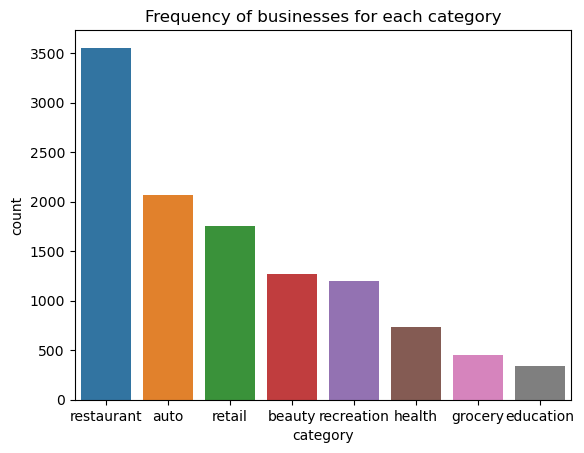

In [5]:
sns.countplot(data=yolosac, x='category', order=yolosac['category'].value_counts().index)
plt.title('Frequency of businesses for each category')

Text(0.5, 1.0, 'Frequency of reviews for business categories')

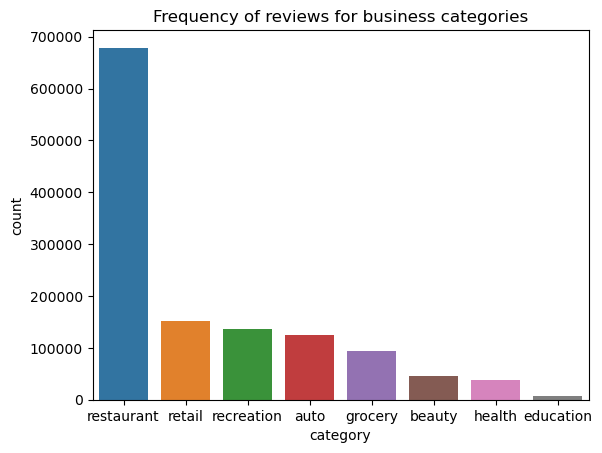

In [6]:
sns.countplot(data=reviews, x='category', order=reviews['category'].value_counts().index)
plt.title('Frequency of reviews for business categories')

Observations:
- About half of all reviews are from restaurants

In [7]:
review_freq_norm = reviews['category'].value_counts() / yolosac['category'].value_counts()
print(review_freq_norm.sort_values(ascending=False))

category
grocery       208.944321
restaurant    190.984524
recreation    114.218984
retail         85.940239
auto           60.371609
health         51.240163
beauty         36.284136
education      19.979710
Name: count, dtype: float64


Observations:
- Grocery businesses get the most reviews on average
- Restaurants get the second most reviews on average
- Educational institutions get the least reviews on average

Questions:
- Grocery business includes big-box stores like Walmart and Target. Do these chains contribute to over-inflated review counts?

Question: What is the distribution of businesses with 1-2, 2-3, 3-4, 4-5 star ratings? Does it vary across business categories?

<Axes: xlabel='avg_rating', ylabel='Count'>

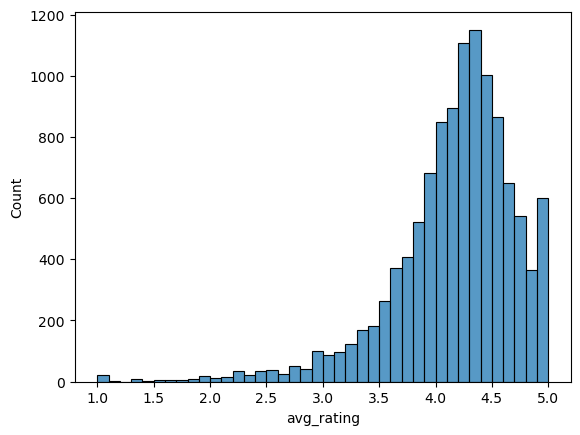

In [8]:
sns.histplot(data=yolosac, x='avg_rating', binwidth=0.1)

Observations:
- Business ratings are highly skewed left

Question:
- Do we need to reduce the number of highy rated businesses in training data?
- What is the cutoff for being a successful business?

In [9]:
# business count for each rating bucket (1-2, 2-3, 3-4, 4-5)
# Lower limit of 0.9 accounts for businesses with 1-star rating
print(pd.cut(yolosac['avg_rating'], [0.9, 2, 3, 4 ,5]).value_counts())

# 4-5 star businesses vs. all other businesses
print(pd.cut(yolosac['avg_rating'], [0.9, 4 ,5]).value_counts())


avg_rating
(4.0, 5.0]    8025
(3.0, 4.0]    2903
(2.0, 3.0]     372
(0.9, 2.0]      74
Name: count, dtype: int64
avg_rating
(4.0, 5.0]    8025
(0.9, 4.0]    3349
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of 4-5 star businesses')

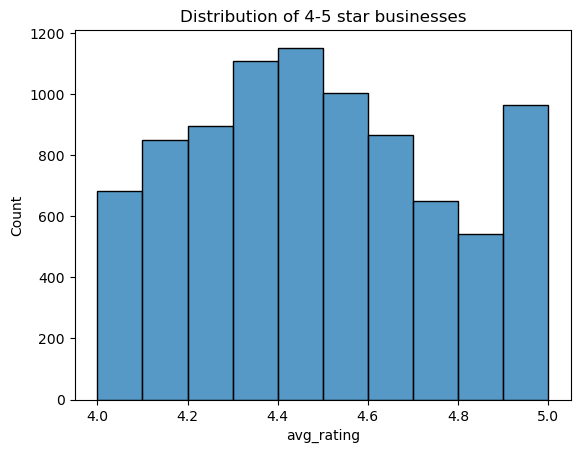

In [10]:
sns.histplot(data=yolosac[(yolosac['avg_rating'] >= 4)], x='avg_rating', bins=10)
plt.title('Distribution of 4-5 star businesses')

4-5 star businesses are roughly normally distributed, except at the right end. This is probably because the last bin includes 5-star businesses that may only have a few reviews.

In [11]:
split_on_ratings = pd.cut(yolosac['avg_rating'], [0.9, 2, 3, 4 ,5])
split_on_ratings.head

<bound method NDFrame.head of 0        (4.0, 5.0]
1        (3.0, 4.0]
2        (4.0, 5.0]
3        (3.0, 4.0]
4        (3.0, 4.0]
            ...    
11425    (4.0, 5.0]
11426    (4.0, 5.0]
11427    (4.0, 5.0]
11428    (4.0, 5.0]
11429    (4.0, 5.0]
Name: avg_rating, Length: 11374, dtype: category
Categories (4, interval[float64, right]): [(0.9, 2.0] < (2.0, 3.0] < (3.0, 4.0] < (4.0, 5.0]]>

In [12]:
print(reviews.dropna().shape)
print(reviews.shape)

(1268124, 4)
(1275985, 4)


## Restaurants

### Restaurant businesses

In [13]:
restaurants = yolosac[yolosac['category'] == 'restaurant']

In [44]:
restaurants.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_rating,3554.0,4.185172,0.421077,1.0,4.0,4.3,4.5,5.0
num_of_reviews,3554.0,190.985650,242.185747,1.0,42.0,111.0,243.0,2945.0


- Average rating ranges from 1 to 5. The IQR is 4 to 4.5 stars. The distribution of ratings for businesses is left skewed.
- Number of reviews per restaurant ranges from 1 to 2945. The IQR is 42 to 243 reviews. 50% of all restaurants receive less than 111 reviews. The distribution is highly right skewed.

**Restaurant Business Reviews**

In [14]:
# restaurant count for each rating bucket (1-2, 2-3, 3-4, 4-5)
# Lower limit of 0.9 accounts for restaurants with 1-star rating
print(pd.cut(restaurants['avg_rating'], [0.9, 2, 3, 4 ,5]).value_counts())

# > 4 star restaurants vs. <= 4 star restaurants
print(pd.cut(restaurants['avg_rating'], [0.9, 4 ,5]).value_counts())

avg_rating
(4.0, 5.0]    2483
(3.0, 4.0]    1017
(2.0, 3.0]      45
(0.9, 2.0]       9
Name: count, dtype: int64
avg_rating
(4.0, 5.0]    2483
(0.9, 4.0]    1071
Name: count, dtype: int64


Observations:
- More than half of all restaurant businesses have an average rating above 4 stars
- Very few have below a 3 star average rating. Perhaps low-rated restaurants go out of business quickly.

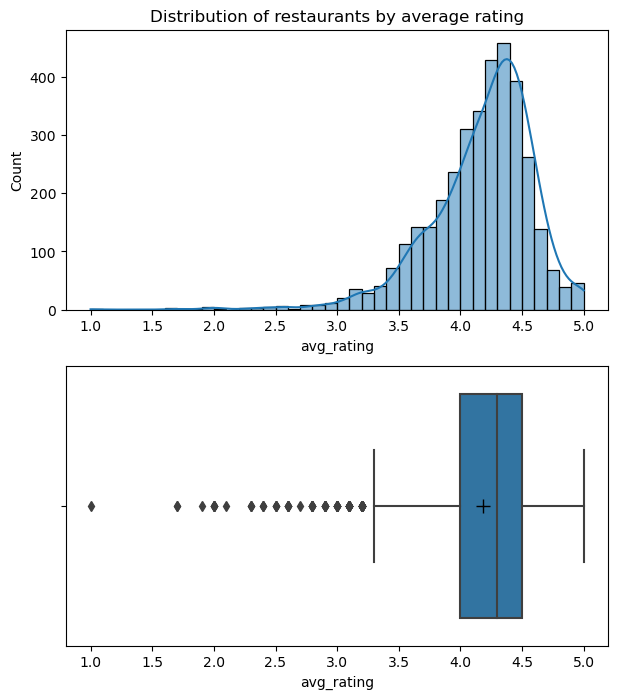

In [15]:
fig, axes = plt.subplots(2, figsize=(7,8))
axes[0].set_title('Distribution of restaurants by average rating')
# Historgram
sns.histplot(data=restaurants, x='avg_rating', binwidth=0.1, ax=axes[0], kde=True)
# Box Plot with mean represented as '+'
sns.boxplot(data=restaurants, x='avg_rating', ax=axes[1], showmeans=True, meanprops={'marker':'+', 'markeredgecolor':'black', 'markersize':10})

plt.show()

Observations:
- Restaurant business ratings are highly skewed left
- Mean review rating is 4.2 stars
- Median review rating is 4.4 stars
- IQR of review ratings is between 4 and 4.5 stars
- There are outliers between 1 and 3.3 stars

**Loading restaurant reviews**

In [16]:
restaurant_reviews = pd.read_json('data/ys-reviews-restaurants.json')

In [35]:
unique_biz = restaurant_reviews['gmap_id'].unique()
for b in unique_biz:
  idx = yolosac[yolosac['gmap_id'] == b].index
  print(b, " Listed # of reviews:", yolosac.at[idx[0],'num_of_reviews'], " Review count:", restaurant_reviews[restaurant_reviews['gmap_id'] == b].shape[0])

0x809ae410bb4b79db:0x8e53e91c4a62cfcd  Listed # of reviews: 16  Review count: 24
0x809ae58e5b6f8889:0x997c522d3d5cf906  Listed # of reviews: 8  Review count: 16
0x80852990182f7d55:0xe7374fc8442789f1  Listed # of reviews: 7  Review count: 8
0x8084d0e5f234f735:0x782262f8c6962382  Listed # of reviews: 8  Review count: 8
0x8084d155d59bbe79:0xea9392e201d6ec6f  Listed # of reviews: 8  Review count: 16
0x809ade2407727363:0x6cb49bc8ac7e5da0  Listed # of reviews: 8  Review count: 8
0x809ad74f05c789b5:0xc27923eb8a9669b9  Listed # of reviews: 18  Review count: 12
0x80852973bd7fdb17:0x37c0de1ef7e95670  Listed # of reviews: 3  Review count: 3
0x809ad1ca09efc1b1:0xfd96a292930a92b1  Listed # of reviews: 2  Review count: 1
0x80852901bfddd01f:0xef5c33acec5ec309  Listed # of reviews: 38  Review count: 31
0x809ada652009e4e1:0xdb82e2d8645add70  Listed # of reviews: 18  Review count: 13
0x80852973bc466539:0x3550cb8cb9ed4fcf  Listed # of reviews: 4  Review count: 4
0x809add6ceed2c42d:0x216464bac4aedd5f  Lis

The listed number of reviews for each restaurant business does not match the number of reviews in our dataset. For simplicity, we will repopulate the restaurant list with the number of reviews we actually have.

In [ ]:
for b in unique_biz:
  idx = restaurants[restaurants['gmap_id'] == b].index
  restaurants.at[idx[0],'num_of_reviews'] = restaurant_reviews[restaurant_reviews['gmap_id'] == b].shape[0]

**Restaurant Review Ratings**

In [17]:
# review count for each rating bucket (1, 2, 3, 4 ,5)
print(restaurant_reviews['rating'].value_counts())

# 5 star reviews vs. all other reviews
print(pd.cut(restaurant_reviews['rating'], [0.9, 4 ,5]).value_counts())

rating
5.0    391725
4.0    131390
1.0     62586
3.0     60430
2.0     32531
Name: count, dtype: int64
rating
(4.0, 5.0]    391725
(0.9, 4.0]    286937
Name: count, dtype: int64


Observations:
- More than half of restaurant reviews are 5 stars.
- 2 star reviews are least common, followed by 3 star reviews

Questions:
- What type of sentiment is associated wth 5-star reviews? Do people tend to give 5 stars when they are satisfied or impressed?
- What are the indicators of a 4-star or lower review?

Text(0.5, 1.0, 'Distribution of restaurant reviews')

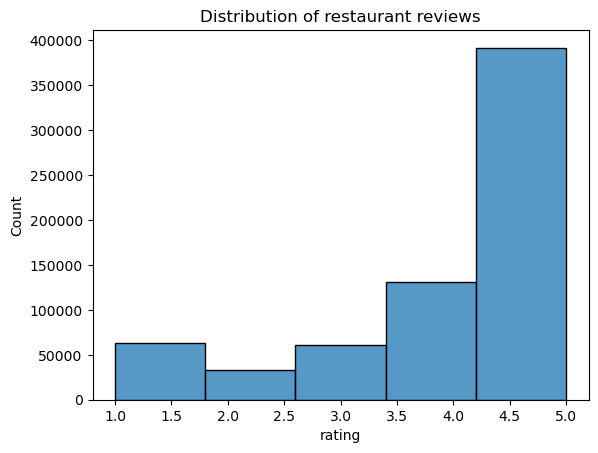

In [18]:
sns.histplot(data=restaurant_reviews, x='rating', bins=5)
plt.title('Distribution of restaurant reviews')

Observations:
- Restaurant review ratings are skewed left

**Number of Reviews**

<Axes: xlabel='num_of_reviews', ylabel='Count'>

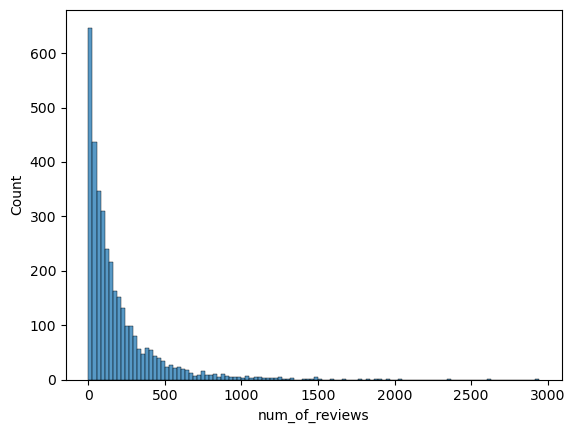

In [42]:
sns.histplot(data=restaurants, x='num_of_reviews')

<Axes: xlabel='num_of_reviews'>

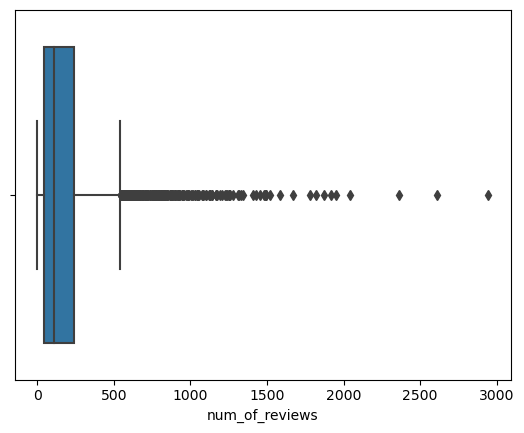

In [43]:
sns.boxplot(restaurants, x='num_of_reviews')

- The number of reviews for each restaurant is highly right-skewed.
- There are a significant amount of outliers, which are restaurants with more than ~550 reviews.

In [51]:
restaurants[restaurants['num_of_reviews'] > 550].sort_values(by='num_of_reviews')

,name,gmap_id,category,avg_rating,num_of_reviews
9887,Jack in the Box,0x809ac5bf608d6af7:0xab9e5ba37437daad,restaurant,3.7,551
10458,Dutch Bros Coffee,0x809ac6dc7d3d1891:0x9381a0aac6e159e8,restaurant,4.6,552
7754,Sushi Hook,0x809ada5b4bbc8643:0xfdaa2e69b8c358eb,restaurant,4.4,554
10000,Arby's,0x809adee8fa860c2b:0x142d965a2c9cda53,restaurant,3.9,555
10376,La Fiesta Alteña Taqueria | Sacramento,0x809ad09458c96b35:0x7af9f0cb40c508ae,restaurant,4.4,557
...,...,...,...,...,...
11296,Texas Roadhouse,0x809ade2fbd691c8d:0x59ccae9cb096e7f9,restaurant,4.4,1950
9876,In-N-Out Burger,0x809ada232de8a467:0x43891169dccf8a93,restaurant,4.6,2042
10958,In-N-Out Burger,0x80859ab5701fef73:0x79427e22f734e4da,restaurant,4.6,2359
9863,Century Arden 14 and XD,0x809ada3c3bbd6b6b:0xaa58a26475e6372a,restaurant,4.7,2609


- Outliers based on number of reviews tend to be chain restaurants
- There are 250 outlier restaurant businesses

## Restaurant Topics

In [19]:
food = pd.read_json('data/topics/food-hits-restaurant-reviews.json')
food.head()

,lemma,doc_index,sentence_index,token_index
0,food,1,1,14
1,chicken,1,2,8
2,food,1,3,5
3,food,2,0,1
4,food,2,1,5


In [52]:
print("# of reviews that mention food:", food['doc_index'].nunique())
print("Total # of reviews:", restaurant_reviews.shape[0])

# of reviews that mention food: 471795
Total # of reviews: 678759


Observations:
- The topic of food appears in about 2/3 of restaurant reviews

## Restaurant Sentiments

In [6]:
sentiments = pd.read_json('restaurant-topic-sentiment.json', orient='index')

In [7]:
sentiments.head()

,pos_food,pos_service,pos_location,pos_clean,pos_price,neg_food,neg_service,neg_location,neg_clean,neg_price,rating
0x809ae410bb4b79db:0x8e53e91c4a62cfcd,1.166667,0.666667,0.00,0.00,0.416667,0.250,0.000,0.000,0.0,0.000,4.2
0x809ae58e5b6f8889:0x997c522d3d5cf906,0.750000,0.250000,0.00,0.00,0.125000,0.375,0.250,0.125,0.0,0.000,3.7
0x80852990182f7d55:0xe7374fc8442789f1,0.750000,0.000000,0.00,0.00,0.000000,0.500,0.250,0.000,0.0,0.000,3.0
0x8084d0e5f234f735:0x782262f8c6962382,0.000000,0.000000,0.25,0.25,0.000000,0.000,0.000,0.000,0.0,0.000,4.3
0x8084d155d59bbe79:0xea9392e201d6ec6f,1.000000,0.125000,0.00,0.00,0.125000,0.250,0.375,0.000,0.0,0.125,3.8


In [34]:
sentiments.describe().T

,count,mean,std,min,25%,50%,75%,max
pos_food,3551.0,0.909753,0.484151,0.0,0.560976,0.910448,1.162791,8.000000
pos_service,3551.0,0.272892,0.134472,0.0,0.185069,0.259861,0.346154,1.055556
pos_location,3551.0,0.210404,0.153152,0.0,0.100139,0.190476,0.284398,2.000000
pos_clean,3551.0,0.035929,0.040982,0.0,0.008299,0.026100,0.050878,0.500000
pos_price,3551.0,0.092599,0.088110,0.0,0.041667,0.078091,0.121845,2.000000
neg_food,3551.0,0.294169,0.228888,0.0,0.164096,0.251462,0.365619,4.000000
neg_service,3551.0,0.100127,0.104753,0.0,0.032981,0.075145,0.136364,1.333333
neg_location,3551.0,0.041003,0.048776,0.0,0.015152,0.030928,0.050725,0.666667
neg_clean,3551.0,0.016769,0.028470,0.0,0.000000,0.007421,0.021739,0.500000
neg_price,3551.0,0.041133,0.052480,0.0,0.013201,0.031250,0.051948,1.000000


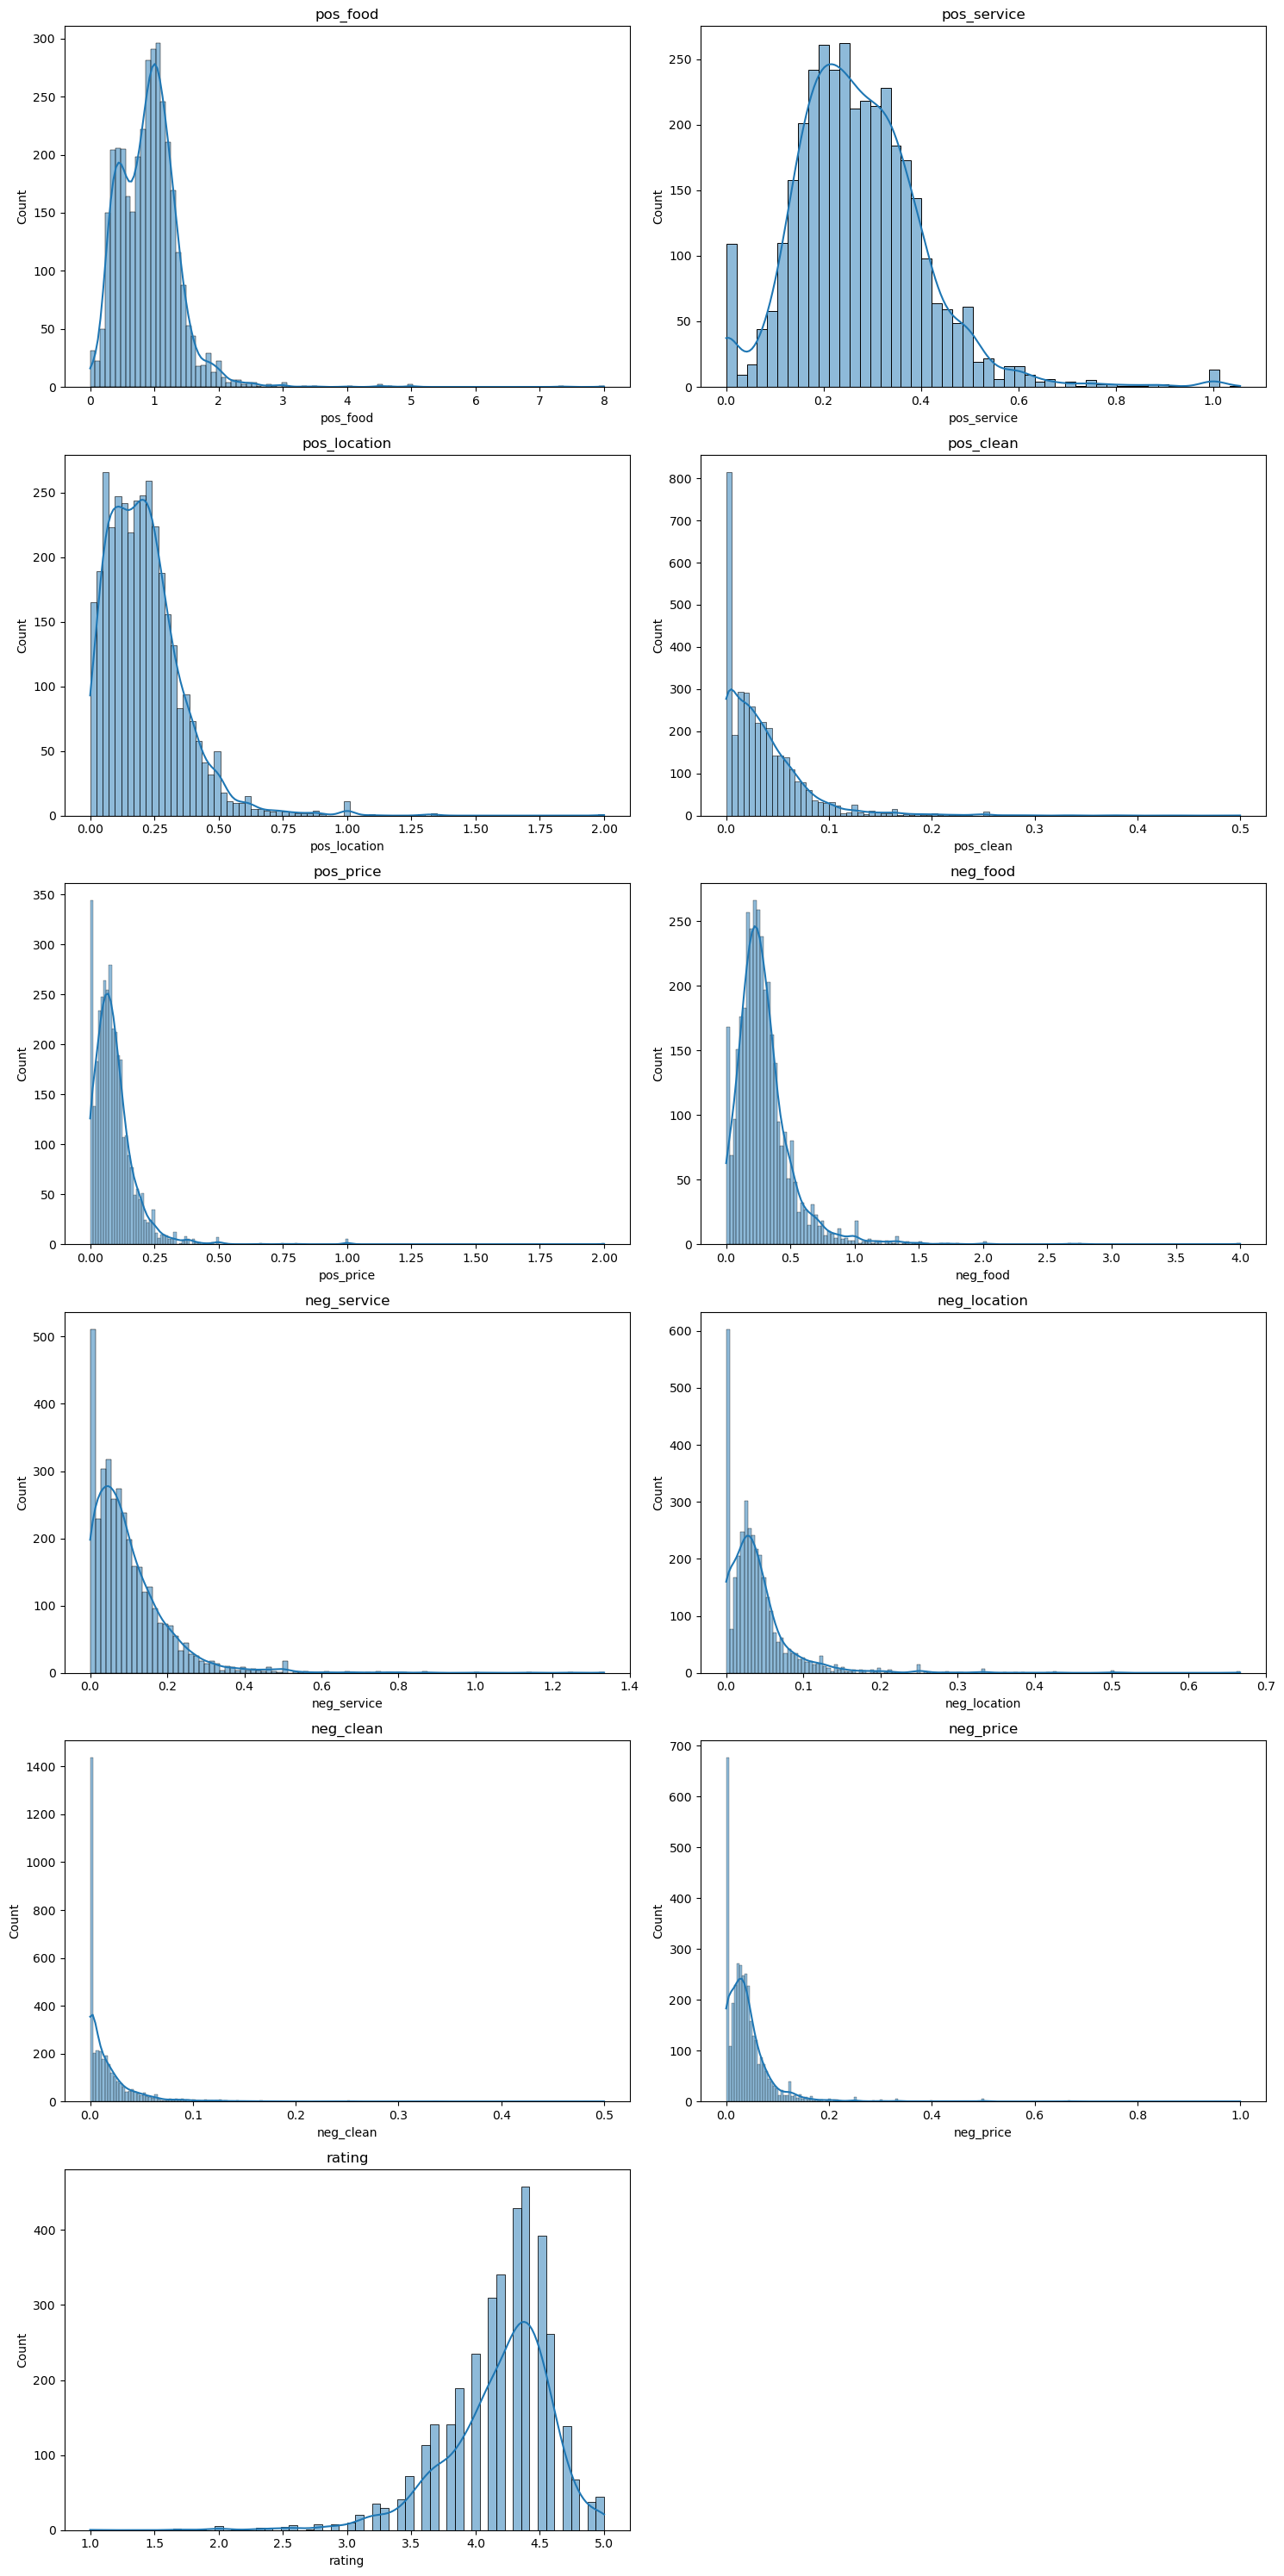

In [30]:
# Set the grid width
grid_width = 2

# Set up the subplots
num_cols = sentiments.shape[1]
num_rows = (num_cols + grid_width - 1) // grid_width
fig, axes = plt.subplots(nrows=num_rows, ncols=grid_width, figsize=(15, 5 * num_rows))

# Plot histograms for each column
for i, column in enumerate(sentiments.columns):
    ax = axes[i // grid_width, i % grid_width]
    sns.histplot(sentiments[column], ax=ax, kde=True)
    ax.set_title(column)

# Remove empty subplots
for j in range(num_cols, num_rows * grid_width):
    fig.delaxes(axes.flatten()[j])
    
# Adjust layout for better visualization
plt.tight_layout()
plt.show()

All of the topic sentiment variables have a high frequency of 0 values. This is because their value is set to zero by default if a topic is not detected in the text.

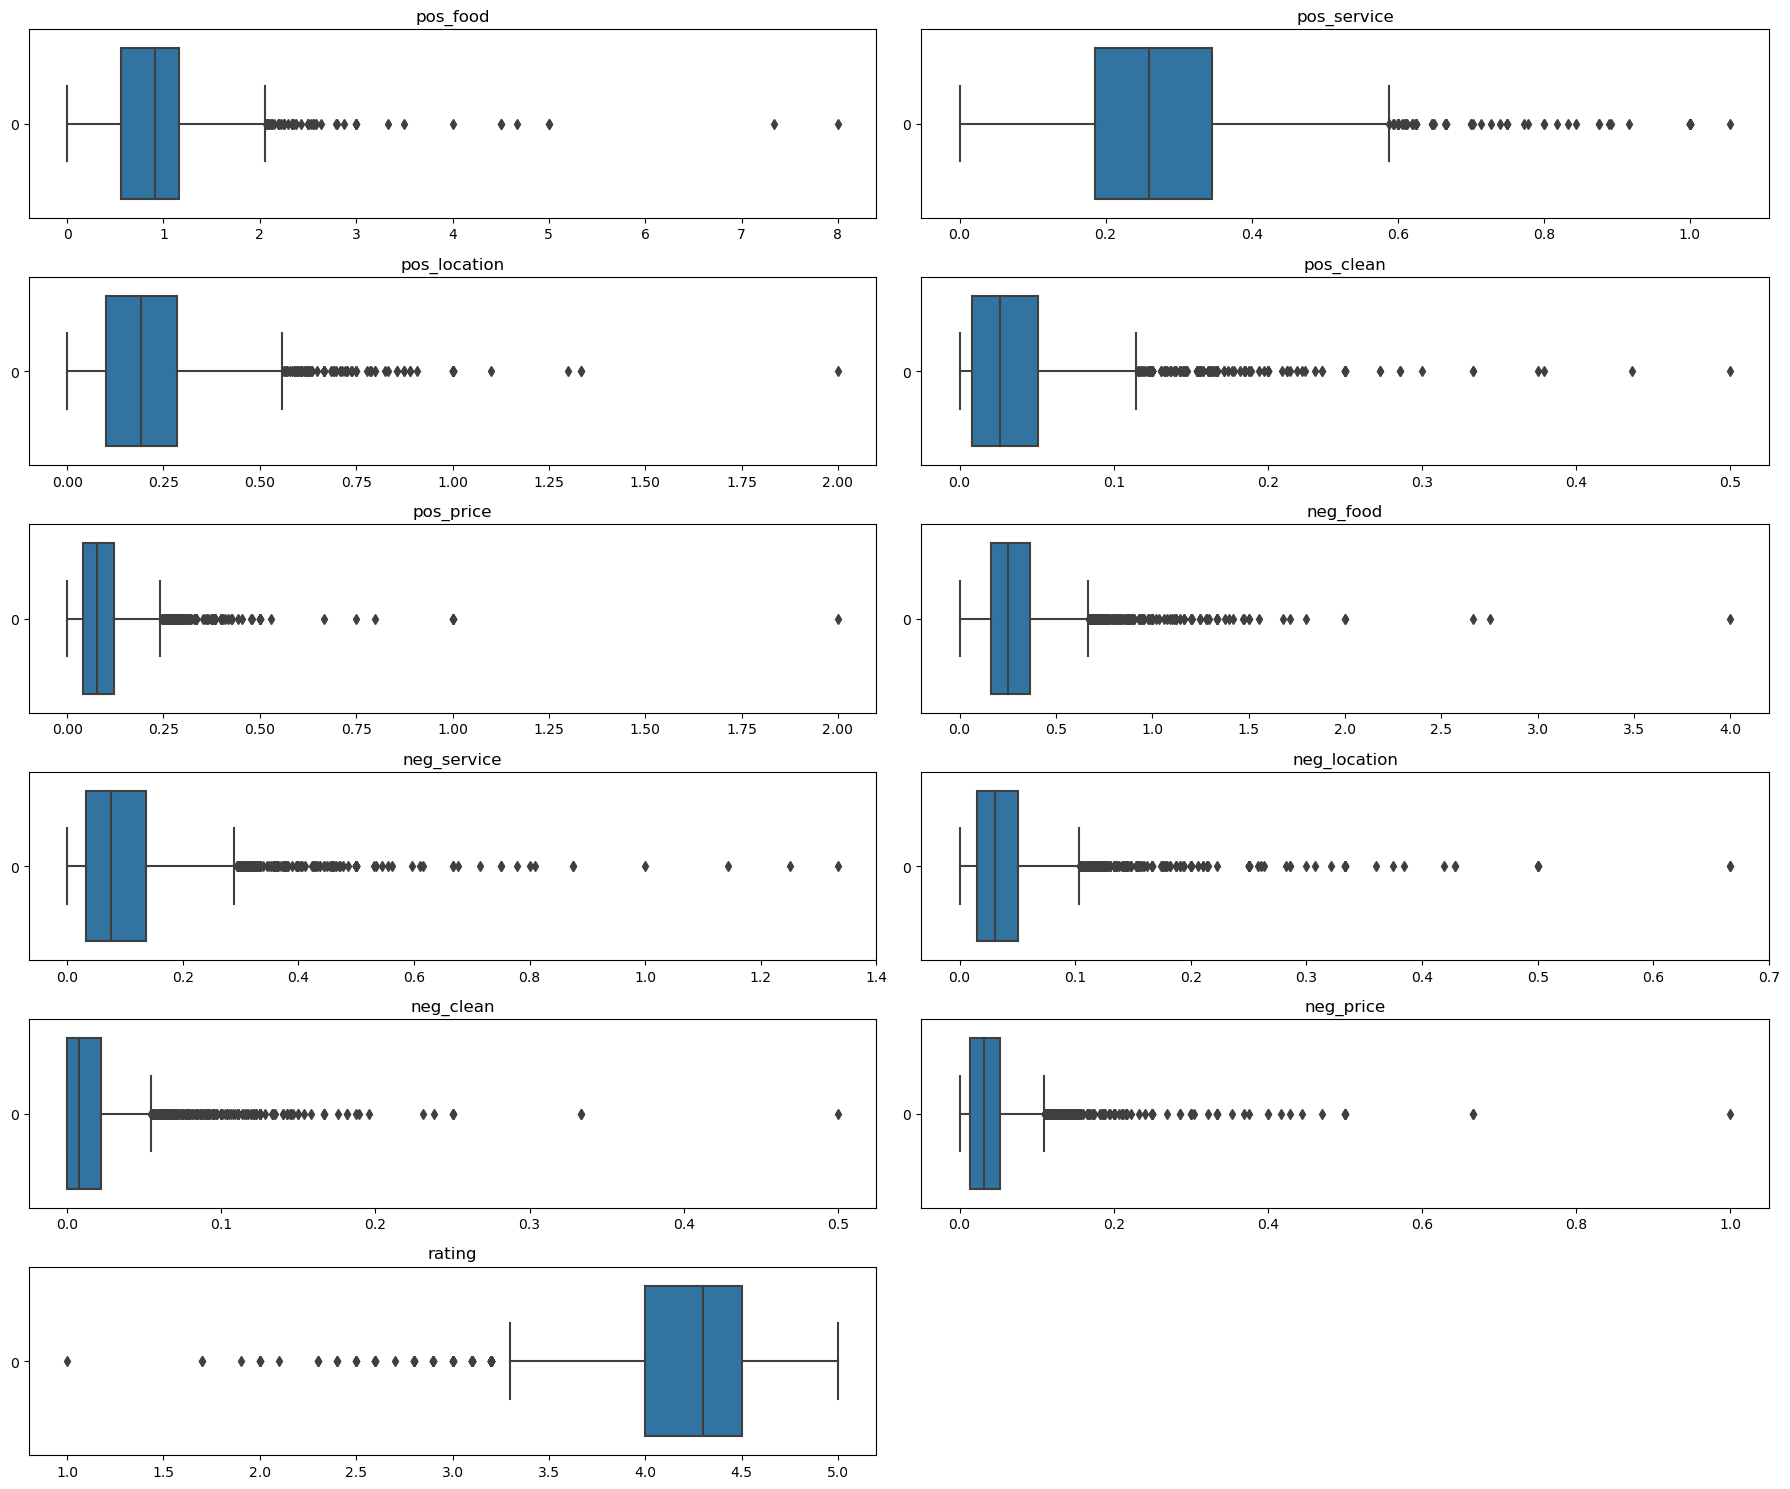

In [29]:
# Set the grid width
grid_width = 2

# Set up the subplots
num_cols = sentiments.shape[1]
num_rows = (num_cols + grid_width - 1) // grid_width
fig, axes = plt.subplots(nrows=num_rows, ncols=grid_width, figsize=(3 * num_rows, 15))

# Plot histograms for each column
for i, column in enumerate(sentiments.columns):
    ax = axes[i // grid_width, i % grid_width]
    sns.boxplot(sentiments[column], ax=ax, orient='h')
    ax.set_title(column)

# Remove empty subplots
for j in range(num_cols, num_rows * grid_width):
    fig.delaxes(axes.flatten()[j])
    
# Adjust layout for better visualization
plt.tight_layout()
plt.show()

All of the topic sentiment scores are right skewed, with outliers on the right end.

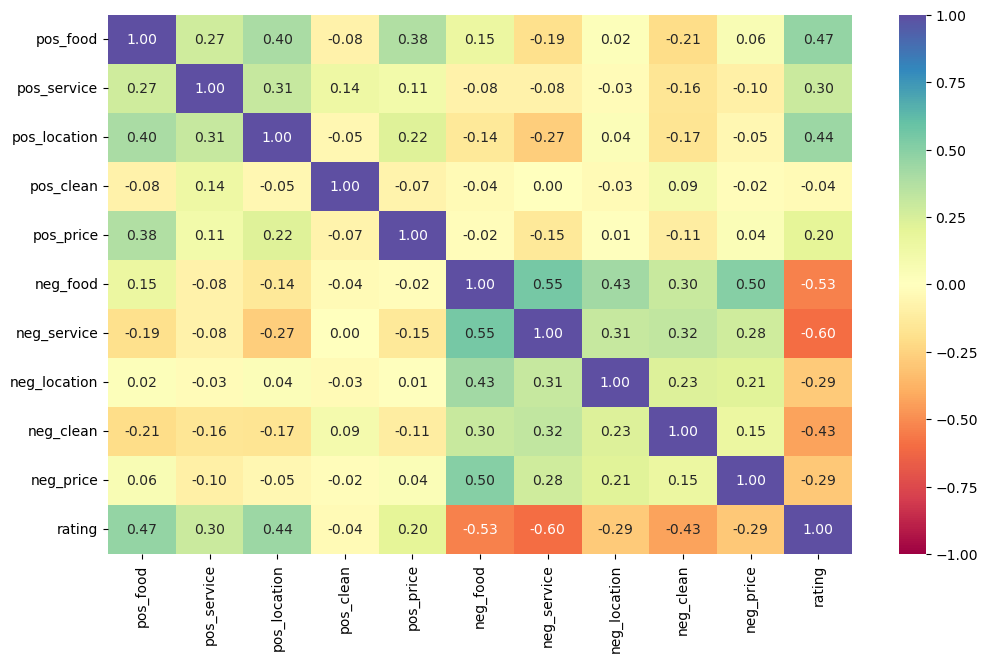

In [32]:
cols_list = sentiments.columns.tolist()

plt.figure(figsize=(12, 7))
sns.heatmap(sentiments[cols_list].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

- Rating has strong positive correlation with pos_food, pos_location, and pos_service
- Rating has strong negative correlation with neg_service, neg_food, and neg_clean

### Removing Outliers

In [40]:
# Define a function to remove rows with outliers in any column based on IQR
def remove_outliers(df):
    df_no_outliers = df.copy()

    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define the upper and lower bounds to identify outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify rows with outliers in the current column
        outliers_mask = (df[column] < lower_bound) | (df[column] > upper_bound)

        # Remove rows with outliers for the current column
        df_no_outliers = df_no_outliers[~outliers_mask]

    return df_no_outliers

# Remove rows with outliers in any column
sentiments_no_outliers = remove_outliers(sentiments)

# Display the DataFrame without outliers
print(sentiments_no_outliers)


                                       pos_food  pos_service  pos_location  \
0x80852973bd7fdb17:0x37c0de1ef7e95670  0.333333     0.333333      0.333333   
0x809ad1ca09efc1b1:0xfd96a292930a92b1  1.000000     0.000000      0.000000   
0x809add6ceed2c42d:0x216464bac4aedd5f  1.000000     0.000000      0.000000   
0x809ad7381afd6843:0xceaecec727b67574  0.271186     0.355932      0.033898   
0x809add83d139db0f:0x5949292ed83aba25  1.000000     0.500000      0.500000   
...                                         ...          ...           ...   
0x809ae5006006087b:0x8c7adb7c03ebaca9  0.622517     0.344371      0.168874   
0x809ae486e766bf13:0x56fa6eebc6e42ad5  0.868421     0.368421      0.236842   
0x809ae41d3806acef:0x537909d76379614b  1.007576     0.424242      0.272727   
0x809ad0dc95d366e1:0xd01da213a959bf71  1.014085     0.169014      0.214085   
0x809add6b67412841:0x51386482530fe0d9  1.026515     0.329545      0.219697   

                                       pos_clean  pos_price  ne

/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_74970/2939526816.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_no_outliers = df_no_outliers[~outliers_mask]
/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_74970/2939526816.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_no_outliers = df_no_outliers[~outliers_mask]
/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_74970/2939526816.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_no_outliers = df_no_outliers[~outliers_mask]
/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_74970/2939526816.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_no_outliers = df_no_outliers[~outliers_mask]
/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_74970/2939526816.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_

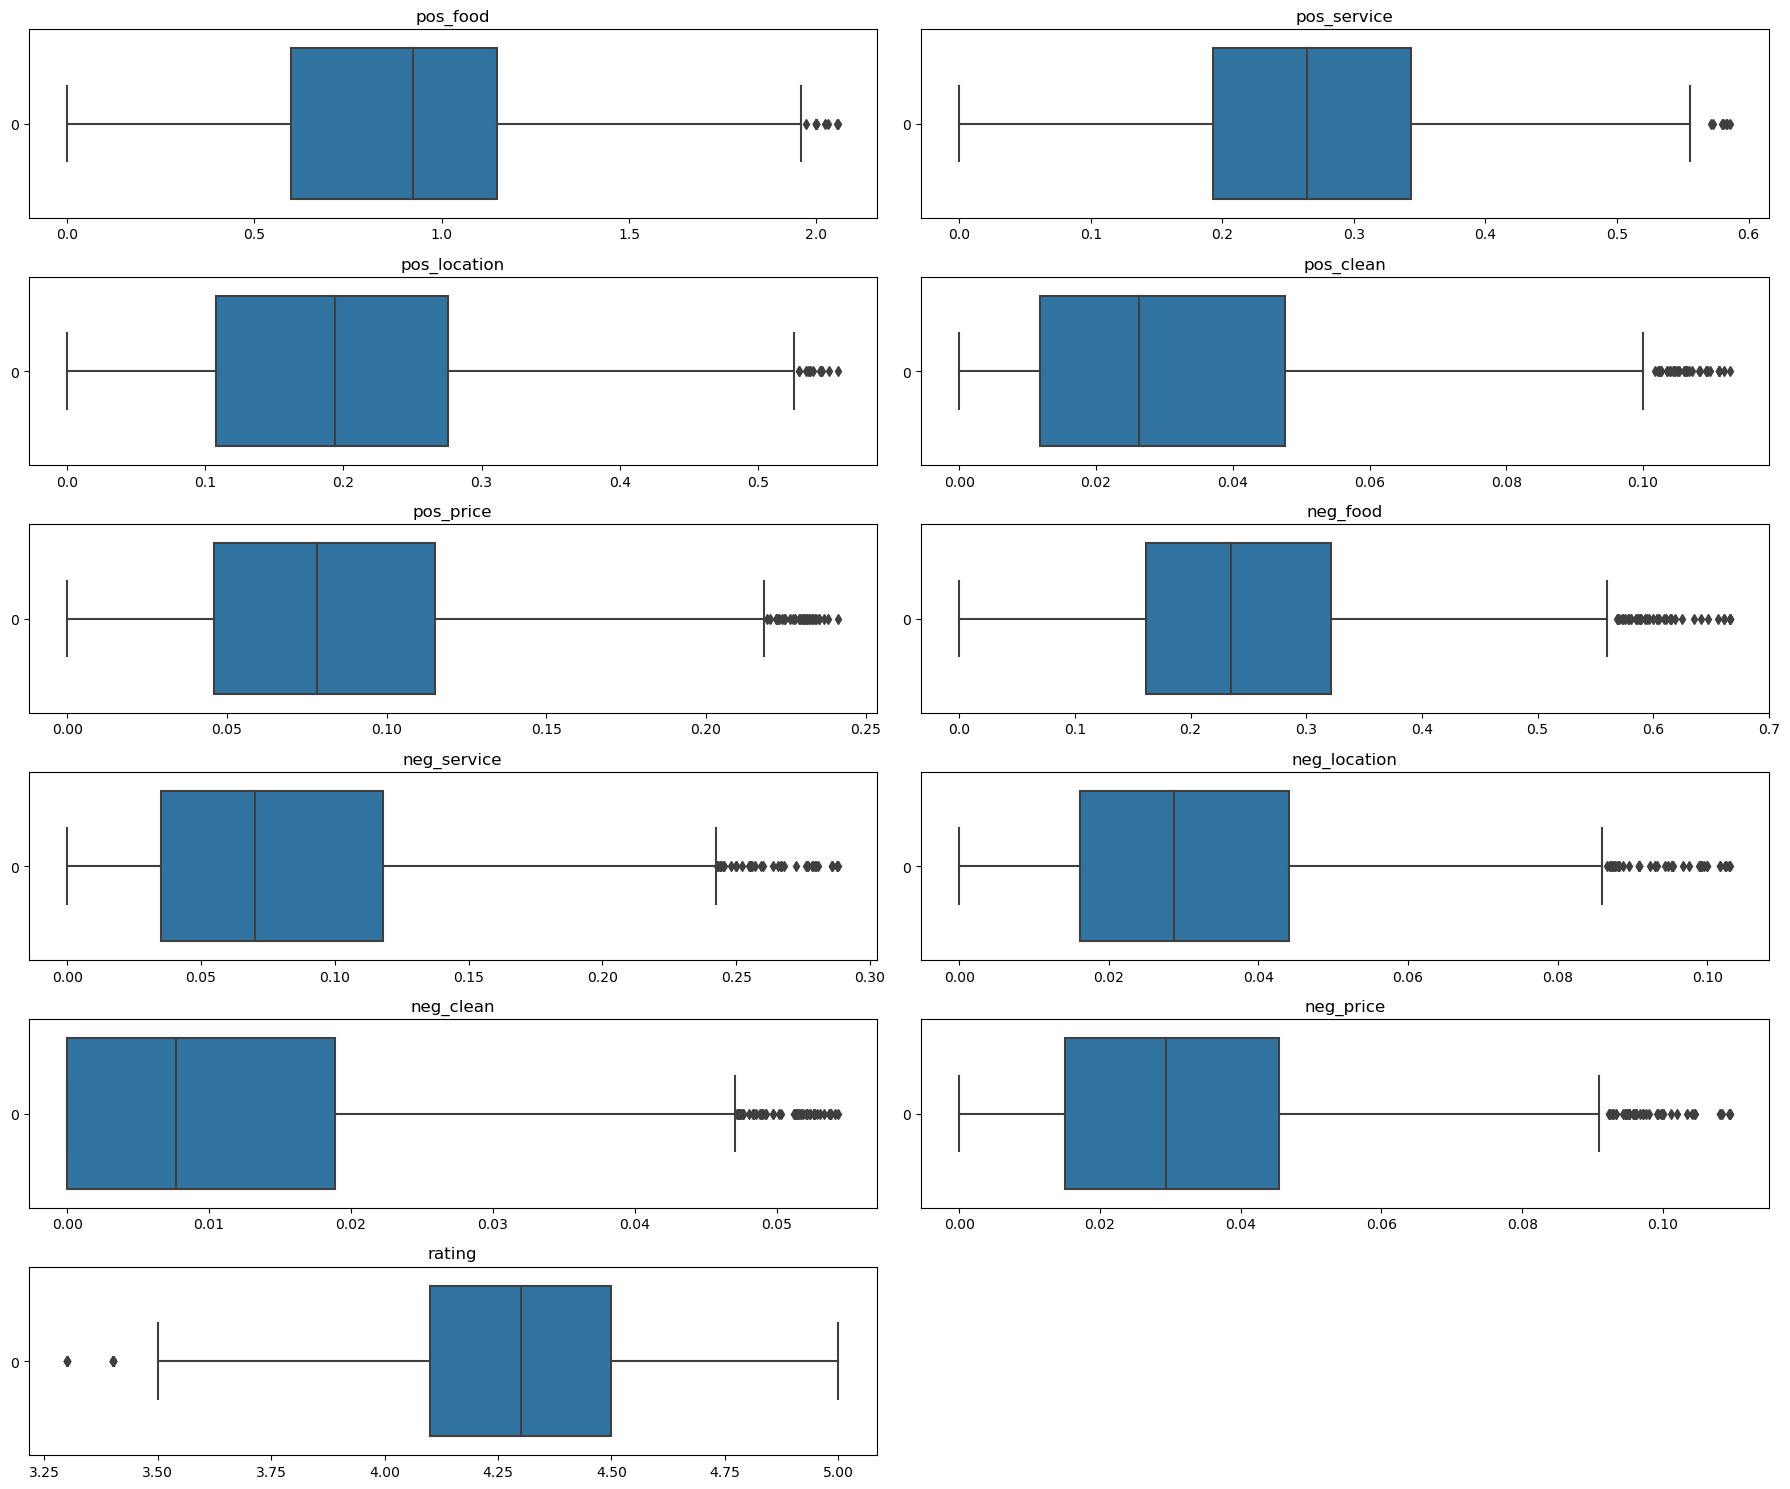

In [42]:
# Set the grid width
grid_width = 2

# Set up the subplots
num_cols = sentiments_no_outliers.shape[1]
num_rows = (num_cols + grid_width - 1) // grid_width
fig, axes = plt.subplots(nrows=num_rows, ncols=grid_width, figsize=(3 * num_rows, 15))

# Plot histograms for each column
for i, column in enumerate(sentiments_no_outliers.columns):
    ax = axes[i // grid_width, i % grid_width]
    sns.boxplot(sentiments_no_outliers[column], ax=ax, orient='h')
    ax.set_title(column)

# Remove empty subplots
for j in range(num_cols, num_rows * grid_width):
    fig.delaxes(axes.flatten()[j])
    
# Adjust layout for better visualization
plt.tight_layout()
plt.show()

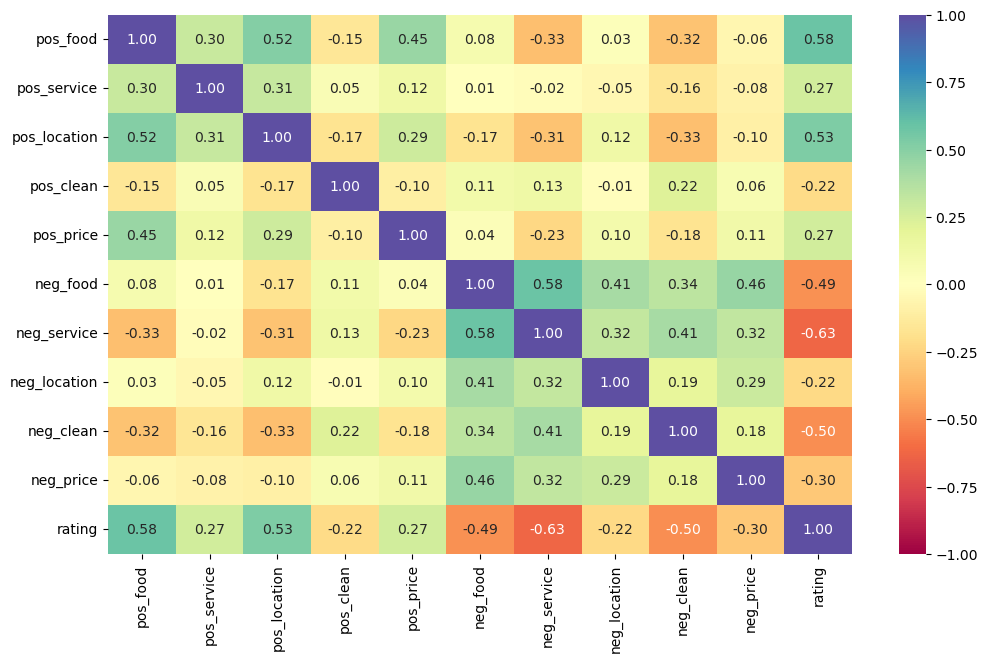

In [43]:
cols_list = sentiments_no_outliers.columns.tolist()

plt.figure(figsize=(12, 7))
sns.heatmap(sentiments_no_outliers[cols_list].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()